## SVD 

https://my.oschina.net/u/1462678/blog/893835

A = U*S*V’

其中S=diag(σ i ,σ 2 ,……,σ r )，**σ i >0**  (i=1,…,r)，**r=rank(A)** 。

- 第一个矩阵X中的每一行表示意思相关的一类词，其中的每个非零元素表示这类词中每个词的重要性（或者说相关性），数值越大越相关。
- 最后一个矩阵Y中每一列表示同一主题一类文章，其中每个元素表示这类文章中每篇文章的相关性。
- 中间的矩阵则表示类词和文章雷之间的相关性。因此，我们只要对关联矩阵A进行一次奇异值分解，我们就可以同时完成近义词分类和文章的分类。（**同时得到每类文章和每类词的相关性**）。
- 这个矩阵很**稀疏**，所以要求**满秩分解**。


<img src='https://static.oschina.net/uploads/img/201705/06144126_Wrnk.jpg'>

**将这个矩阵进行SVD，得到下面的矩阵：**

<img src='https://static.oschina.net/uploads/img/201705/06144126_ofVI.jpg'>

**左奇异向量表示“词”的一些特性，右奇异向量表示“文档”的一些特性，中间的奇异值矩阵表示左奇异向量的”一行“与右奇异向量的“一列”的重要程序，数字越大越重要。**


- 左奇异向量的第一列表示**每一篇文档中**每一个词的出现频繁程度,但不是线性的
- 右奇异向量中的第一行表示**每一篇文档**中出现的属于该topic的词的个数的近似。在原始矩阵中，我们知道每个Topic中都包含哪些词
- 将原来words与topic的矩阵，分解为words in document 和 topic words in documents，和他们之间关系的3个矩阵

### 针对评分预测的真实含义

- 用户u和每个特征的关系
- 物品i和每个特征的关系
- 预测用户u对物品i的得分
- 其中，特征是我们并不知道具体有几个，到底是什么。好比user有的喜欢字少的，有的就是喜欢那家店，等等，我们是无法认为定义和分出来的，类似“隐语义”。

## SVD & NMF

- PCA与NMF都是矩阵降维
- SVD是矩阵分解，得到3个矩阵相乘，有明确的含义

## Surprise

https://github.com/NicolasHug/Surprise

In [3]:
import pandas as pd
from surprise import SVDpp, Reader, Dataset

In [4]:
## load data
user_data = pd.read_csv('User Data.csv')

In [5]:
## train set
train_df = user_data[['User ID', 'User Read Books (2017)', 'Average Rating (2017)']]
train_df.head()

,User ID,User Read Books (2017),Average Rating (2017)
0,ID790145788,6254,3.115447
1,ID646234447,"5854, 5676, 7265, 6051",3.157876
2,ID86918707,5815,1.512284
3,ID404262345,"6969, 7002, 5761",3.641681
4,ID267634255,"7908, 7585, 7655, 5013, 5352, 7753, 5793",2.506743


In [6]:
# 将read books拆开，与ID形成对应。
train_ar = [[a[0], int(b), float(a[2])] for a in train_df.values for b in a[1].split(', ')]
user_book_rate = pd.DataFrame(train_ar, columns=train_df.columns)

In [8]:
# Y是平均评分，因为不是真实评分，所以不是很准确
user_book_rate.head()

,User ID,User Read Books (2017),Average Rating (2017)
0,ID790145788,6254,3.115447
1,ID646234447,5854,3.157876
2,ID646234447,5676,3.157876
3,ID646234447,7265,3.157876
4,ID646234447,6051,3.157876


- https://surprise.readthedocs.io/en/stable/reader.html
- The Reader class is used to **parse a file containing ratings**.
- each line needs to respect the following structure: **user ; item ; rating ; [timestamp]**

### model and training

In [23]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(user_book_rate, reader)
data

In [24]:
?SVDpp

In [25]:
# Do not split the dataset into folds and just return a trainset as is, built from the whole dataset.
# Returns: The Trainset.
trainset = data.build_full_trainset()
# 满秩只有一个解，这个factor代表了什么？
algo = SVDpp(n_factors=100,n_epochs=300,lr_all=0.01,reg_all=0.2)
algo.fit(trainset)

In [38]:
user_book_rate.values

array([['ID790145788', 6254, 3.1154469625769927],
       ['ID646234447', 5854, 3.1578759344849705],
       ['ID646234447', 5676, 3.1578759344849705],
       ...,
       ['ID257231817', 6397, 1.4268081150497691],
       ['ID257231817', 6842, 1.4268081150497691],
       ['ID257231817', 7862, 1.4268081150497691]], dtype=object)

In [47]:
user_book_rate.iloc[:,0][:5]

0    ID790145788
1    ID646234447
2    ID646234447
3    ID646234447
4    ID646234447
Name: User ID, dtype: object

In [52]:
user_book_rate.iloc[:,1][:5]

0    6254
1    5854
2    5676
3    7265
4    6051
Name: User Read Books (2017), dtype: int64

In [43]:
user_book_rate.values

array([['ID790145788', 6254, 3.1154469625769927],
       ['ID646234447', 5854, 3.1578759344849705],
       ['ID646234447', 5676, 3.1578759344849705],
       ...,
       ['ID257231817', 6397, 1.4268081150497691],
       ['ID257231817', 6842, 1.4268081150497691],
       ['ID257231817', 7862, 1.4268081150497691]], dtype=object)

** 不能cross_validation,因为每个用户都不一样，shuffle了就等于用用户A来预测用户B的评分，肯定准确率很低**

In [ ]:
y = user_book_rate['Average Rating (2017)']
y_predict = []
for b in user_book_rate.values:
    y_predict.append(algo.predict(b[0], b[1]).est)

In [65]:
y.values

array([3.11544696, 3.15787593, 3.15787593, ..., 1.42680812, 1.42680812,
       1.42680812])

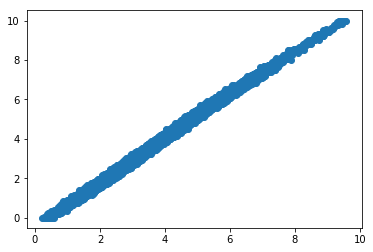

In [67]:
import matplotlib.pyplot as plt
plt.scatter(y_predict, y.values)

In [62]:
from sklearn import metrics
print("Training MSE:",metrics.mean_squared_error(y, y_predict))

Training MSE: 0.05068062912726949


### Conclusion
- MSE要比线性模型要大十倍，但是最终在测试集的准确率却高很多
- 线性模型中，较少的parameter效果也更好
- 在train上MSE太小，过拟合严重，在测试应用时并不好。

### test dataset on year 2018

In [16]:
test_df = user_data[['User ID', 'User Read Books (2018)']]
test_ar = [[a[0], int(b)] for a in test_df.values for b in a[1].split(', ')]
test_ar[:5]

[['ID790145788', 7180],
 ['ID646234447', 5729],
 ['ID646234447', 5279],
 ['ID646234447', 6242],
 ['ID646234447', 5519]]

In [17]:
## final result
final_df = user_data[['User ID', 'User Read Books (2017)', 'User Read Books (2018)', 'Average Rating (2017)']]
final_ar = [[a[0], (len(a[1].split(', ')) * float(a[3]) + 
                    sum([algo.predict(a[0], int(b)).est for b in a[2].split(', ')])) / (len(a[1].split(', ')) + len(a[2].split(', ')))] for a in final_df.values]

预测的分数：并没有只预测2018年的，而是与2017年的做了融合。

$$ \frac{2017总分+2018总分}{ 2017个数+2018个数 }$$

In [19]:
final_ar[:5]

[['ID790145788', 3.308435845966358],
 ['ID646234447', 3.1955635654019736],
 ['ID86918707', 2.0885072067409145],
 ['ID404262345', 3.7324888219942545],
 ['ID267634255', 2.6861696476245935]]

In [21]:
rel = pd.DataFrame(final_ar, columns=['User ID', 'Average Rating (2018)'])
rel.head()

,User ID,Average Rating (2018)
0,ID790145788,3.308436
1,ID646234447,3.195564
2,ID86918707,2.088507
3,ID404262345,3.732489
4,ID267634255,2.686170


In [22]:
# ## save to csv -> submission
# rel.to_csv('out.csv', index=False)

## SVD与SVD++

https://blog.csdn.net/wjmishuai/article/details/71191945

#### SVD：

最为常见的用户给电影评分的场景，我们需要一个数学模型来模拟用户给电影打分的场景，比如对评分进行预测。

将评分矩阵U看作是两个矩阵的乘积：

$u_{xy}$ 可以看作是user x对电影的**隐藏特质y**的热衷程度，而$i_{yz}$可以看作是特质 y 在电影 z中的体现程度。**q 和 p 分别对应了电影和用户在各个隐藏特质上的特征向量。**这个模型里，用户和电影被认为是没有偏好的，是客观无差别的，但这并不是事实。那么上述模型的评分预测公式为：

<img src='https://upload-images.jianshu.io/upload_images/1825662-558bec2e42b38f90.png'>

为了体现用户，电影他们的每个个体的特质都是有差别的，例如某些用户非常挑剔，总是给予很低的评分；或是某部电影拍得奇烂，恶评如潮。为了模拟以上的情况，需要引入 **baseline predictor**.

其中 μ 为所有评分基准，$b_i$ 为电影 i 的评分均值相对μ的偏移，$b_u$ 类似。

<img src='https://upload-images.jianshu.io/upload_images/1825662-5c6a60bc8a584dca.png'>

模型参数$b_i,b_u,q_i,p_u$通过最优化下面这个目标函数获得：

<img src='https://upload-images.jianshu.io/upload_images/1825662-dc944baad3a10129.png'>

#### SVD++

某个用户对某个电影进行了评分，那么说明他看过这部电影，那么这样的行为事实上蕴含了一定的信息，因此我们可以这样来理解问题：评分的行为从侧面反映了用户的喜好，可以将这样的反映通过**隐式参数**的形式体现在模型中。

其中 $I_u$ 为该用户所评价过的所有电影的集合，$y_j$为隐藏的“评价了电影 j”反映出的个人喜好偏置。将user看过的电影集合作为一个参数，与user vector相加，再与item vector相乘。

<img src='https://upload-images.jianshu.io/upload_images/1825662-c5510b3918fc3bbd.png'>

- Netflix Prize and SVD 的paper

http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf